In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
from operator import itemgetter
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from pylab import savefig
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.cross_validation import random_train_test_split
import numpy as np
from scipy.sparse import csr_matrix
import scipy

from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt


from sklearn.metrics import mean_squared_error

C:\Users\user\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
import matplotlib.pyplot as plt  # Matlab-style plotting
from IPython.display import display
import seaborn as sns
print("Imported seaborn libraries!")

Imported seaborn libraries!


In [4]:
# @title Imports (run this cell)
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
#print("Installing Altair...")
#!pip install git+git://github.com/altair-viz/altair.git
#import altair as alt
#alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')
#print("Done installing Altair.")

# Install spreadsheets and import authentication module.
#USER_RATINGS = False
#!pip install --upgrade -q gspread
#from google.colab import auth
#import gspread
#from oauth2client.client import GoogleCredentials

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

Firstly, I converted my data files from .dat to .csv format. I did this via excel using the data tab and it's "get external data" option and extracted it from text. All the delimiting was done by default and I had my files in a delimited format.

In [6]:
df = pd.read_csv("data/hetrec2011-lastfm-2k/artists.csv")
df

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [7]:
df['id'] = pd.to_numeric(df['id'])
lst = []
m = np.array(df['id'])
for i in range(0,17632):
    #print(i)
    if i not in df.id.values:
        lst.append(i)

len(lst)

965

In [8]:
newart = []
for i in range(0, 17632):
    newart.append(i)

In [9]:
newart = np.array(newart)
df['artID'] = newart.tolist()

In [10]:
df.drop(columns=['id'], inplace=True)
df.head()

,name,url,pictureURL,artID
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0
1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1
2,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...,2
3,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...,3
4,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...,4


There appears to be some unclean names such as "Diamanda GalÃ¡s" among others just taking an initial look at the data here.

In [11]:
df1 = pd.read_csv("data/hetrec2011-lastfm-2k/tags.csv")
df1

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [12]:
df2 = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.csv")
df2

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [13]:
df2['artistID'].min()

1

In [14]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df2["userID"] = df2["userID"].apply(lambda x: str(x-2))
df2["artistID"] = df2["artistID"].apply(lambda x: str(x-1))

In [15]:
df2['userID'] = df2['userID'].astype(int)
xyz =  np.array(df2['userID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [16]:
vals[-1]

2098

In [17]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [18]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [19]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [20]:
s = df2['userID']

df2['userID'] = s.map(dictionary)

In [21]:
df2.head()

,userID,artistID,weight
0,0,50,13883
1,0,51,11690
2,0,52,11351
3,0,53,10300
4,0,54,8983


In [22]:
df2['artistID'] = df2['artistID'].astype(int)
xyz =  np.array(df2['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [23]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[0]

0

In [24]:
usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

17631

In [25]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [26]:
s = df2['artistID']

df2['artistID'] = s.map(diction)

In [27]:
df2['weight'].max()

352698

In [28]:
df2

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
92829,1891,17615,337
92830,1891,17616,297
92831,1891,17617,281
92832,1891,17618,280


In [29]:
df3 = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.csv")
df3

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [30]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df3["userID"] = df3["userID"].apply(lambda x: str(x-2))
df3["friendID"] = df3["friendID"].apply(lambda x: str(x-2))

df3['userID'] = pd.to_numeric(df3['userID'])
df3['friendID'] = pd.to_numeric(df3['friendID'])

In [31]:
df3['friendID'].max()

2098

In [32]:
df3['friendID'].nunique()

1892

In [33]:
xyz =  np.array(df3['userID'])
#zzz = np.array(df2['userID'])
vals = []
for i in range(len(xyz)):
    if xyz[i] not in vals:
        vals.append(xyz[i])

In [34]:
unique_list = list(set(vals))
unique_list.sort()
unique_list[-1]

2098

In [35]:
usenew = []
for i in range(0, 1892):
    usenew.append(i)

usenew[-1]

1891

In [36]:
keys = unique_list
values = usenew
dictionary = dict(zip(keys, values))
#print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [37]:
s = df3['userID']

df3['userID'] = s.map(dictionary)

In [38]:
o = df3['friendID']

df3['friendID'] = o.map(dictionary)

In [39]:
df3['friendID'].max()

1891

In [40]:
df3.isnull().values.any()

False

In [41]:
df4 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists-timestamps.csv")
df4

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [42]:
# Since the ids start at 2, we get them to start at 0. We also need to have the max value 1 less than the no of unique values.
df4["userID"] = df4["userID"].apply(lambda x: str(x-2))
df4["artistID"] = df4["artistID"].apply(lambda x: str(x-1))

df4['artistID'] = df4['artistID'].astype(int)
df4['userID'] = df4['userID'].astype(int)

In [43]:
xyz =  np.array(df4['artistID'])
#zzz = np.array(played['userID'])
vals = []
for i in range(len(xyz)):
    v = xyz[i]
    if v not in vals:
        vals.append(v)
    else:
        continue

In [44]:
unique_list = list(set(vals))
unique_list.sort()
print(unique_list[-1])

usenew = []
for i in range(0, 17632):
    usenew.append(i)

usenew[-1]

18743


17631

In [45]:
keys = unique_list
values = usenew
diction = dict(zip(keys, values))
#print(diction) # {'a': 1, 'b': 2, 'c': 3}

In [46]:
s = df4['artistID']

df4['artistID'] = s.map(diction)

In [47]:
s = df4['userID']

df4['userID'] = s.map(dictionary)
#print(dictionary)

In [48]:
df4

,userID,artistID,tagID,day,month,year
0,0,49,13,1,4,2009
1,0,49,15,1,4,2009
2,0,49,18,1,4,2009
3,0,49,21,1,4,2009
4,0,49,41,1,4,2009
...,...,...,...,...,...,...
186474,1891,11288,4,1,7,2010
186475,1891,11288,292,1,5,2010
186476,1891,11288,2087,1,7,2010
186477,1891,11288,2801,1,5,2010


In [49]:
df5 = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists.csv")
df5

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


Our last two dataframes seem exactly the same. Let's check this before we delete anything.

In [50]:
def checkequality(A, B):

    df11 = A.sort_index(axis=1)
    df11 = df11.sort_values(df11.columns.tolist()).reset_index(drop=True)

    df22 = B.sort_index(axis=1)
    df22 = df22.sort_values(df22.columns.tolist()).reset_index(drop=True)
    return (df11 == df22).values.all()

a = checkequality(df4, df5)
print (a)

False


Two of our files are exactly the same. We can delete one of these accordingly.

In [51]:
del df5

In [52]:
df.info

<bound method DataFrame.info of                     name                                           url  \
0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
4            Bella Morte          http://www.last.fm/music/Bella+Morte   
...                  ...                                           ...   
17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
17628             Aya RL               http://www.last.fm/music/Aya+RL   
17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   

                                              pictureURL  artID  
0        http

# Methodology
Now that all our data files are read in and in the appropriate format we will begin our end to end process. These are as follows:
##### 1. Data cleaning and processing
##### 2. Visualization
##### 3. Fitting our Model
##### 4. Evaluating our Model

# Cleaning and Processing

### Initial analysis and cleaning

In [53]:
df['name'].value_counts()

Skalpel                      1
Chinese Man                  1
Antichristus                 1
Disney                       1
Jessica Andrews              1
                            ..
Cruze & Breaks               1
Ari Koivunen                 1
Jessica Harp                 1
Ð¢Ð¾Ð¼Ð° Ð—Ð´Ñ€Ð°Ð²ÐºÐ¾Ð²    1
Razed in Black               1
Name: name, Length: 17632, dtype: int64

In [54]:
df1['tagID'].value_counts()

2049     1
10904    1
653      1
6798     1
4751     1
        ..
7505     1
1362     1
3411     1
9558     1
2047     1
Name: tagID, Length: 11946, dtype: int64

After initial observation, I feel the timestamp dataframe is of little use to me and hence disregard it. As per the readme file we have 1892 users and 17632 artists in our data.

In [55]:
dfs = [df, df1, df2, df3, df4]
na = []
for i in range(len(dfs)):
    if dfs[i].isnull().values.any() > 0:
        na.append(dfs[i])

In [56]:
na

[                    name                                           url  \
 0           MALICE MIZER         http://www.last.fm/music/MALICE+MIZER   
 1        Diary of Dreams      http://www.last.fm/music/Diary+of+Dreams   
 2      Carpathian Forest    http://www.last.fm/music/Carpathian+Forest   
 3           Moi dix Mois         http://www.last.fm/music/Moi+dix+Mois   
 4            Bella Morte          http://www.last.fm/music/Bella+Morte   
 ...                  ...                                           ...   
 17627    Diamanda GalÃ¡s  http://www.last.fm/music/Diamanda+Gal%C3%A1s   
 17628             Aya RL               http://www.last.fm/music/Aya+RL   
 17629        Coptic Rain          http://www.last.fm/music/Coptic+Rain   
 17630       Oz Alchemist         http://www.last.fm/music/Oz+Alchemist   
 17631   Grzegorz Tomczak     http://www.last.fm/music/Grzegorz+Tomczak   
 
                                               pictureURL  artID  
 0        http://userserve-ak.l

The only dataframe with nulls is our artists dataframe. Let's investigate this further to see if there is any important missing values such as ID's etc.

In [57]:
df.dtypes

name          object
url           object
pictureURL    object
artID          int64
dtype: object

In [58]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(df[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

pictureURL 0.0252 % missing values
['pictureURL']


This is a positive result as there are very few null values in the dataframe and the small amount that exist are in a column of lesser important that we will not need to impute missing values for.

In [59]:
played = pd.merge(df, df2, how="inner", left_on="artID", right_on="artistID")
played.rename(columns={"weight": "played"}, inplace=True)

In [60]:
played

,name,url,pictureURL,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg,1,240,1,152
...,...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...,17627,423,17627,301
92830,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg,17628,423,17628,294
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg,17629,423,17629,287
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...,17630,423,17630,286


We will drop the pictureURL column as there is not much information to be gained and there is some nulls present.

In [61]:
played.drop(columns=['pictureURL'], inplace=True)

In [62]:
played

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152
...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286


In [63]:
mean = played['played'].mean()
print("The mean number of times a user listens to a song is: " + str(mean))

The mean number of times a user listens to a song is: 745.2439300256372


In [64]:
median = played['played'].median()
print("The median number of times a user listens to a song is: " + str(median))

The median number of times a user listens to a song is: 260.0


<AxesSubplot:>

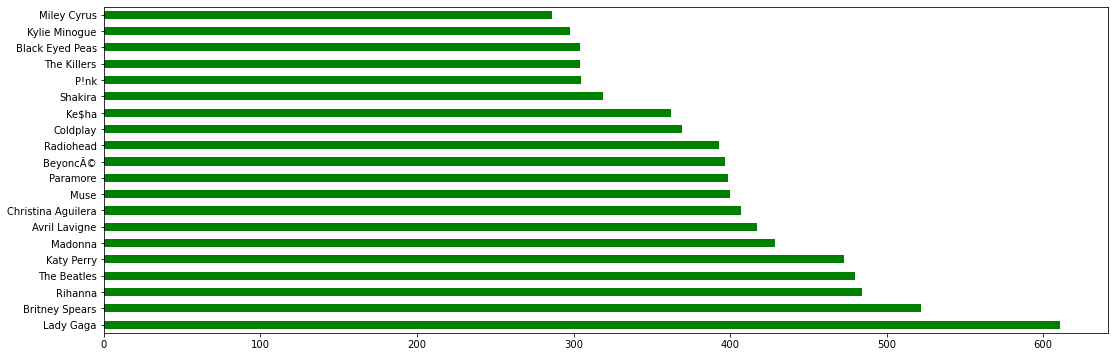

In [65]:
played['name'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))

<AxesSubplot:xlabel='played'>

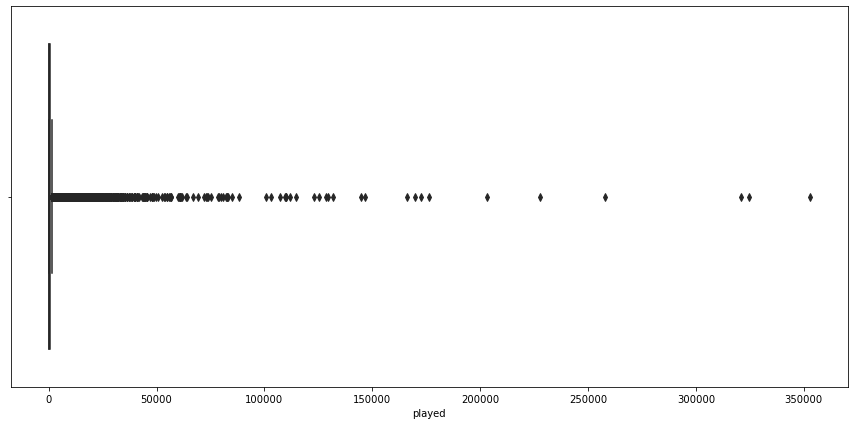

In [66]:
plt.figure(figsize=[15,7])
sns.boxplot(x=played['played'], color=".25")

There appears to be quite a lot of outliers here in the played column. Some users have obviously listened to their songs far more times than the average. We double check our values for mean and median earlier and can confirm there are quite a few outliers here.

In [67]:
played.describe()

,artID,userID,artistID,played
count,92834.000,92834.000,92834.000,92834.000
mean,3235.737,944.222,3235.737,745.244
std,4197.217,546.751,4197.217,3751.322
min,0.000,0.000,0.000,1.000
25%,430.000,470.000,430.000,107.000
50%,1237.000,944.000,1237.000,260.000
75%,4266.000,1416.000,4266.000,614.000
max,17631.000,1891.000,17631.000,352698.000


In [68]:
played.describe(include=[np.object])

<ipython-input-68-1861b8911a57>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  played.describe(include=[np.object])


,name,url
count,92834,92834
unique,17632,17632
top,Lady Gaga,http://www.last.fm/music/Lady+Gaga
freq,611,611


In [69]:
grouped_multiple = played.groupby(['artistID', 'name']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [70]:
artdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [71]:
artdf

,artistID,name,mean,med,max,sum
283,283,Britney Spears,4584.559,1000.500,131733,2393140
66,66,Depeche Mode,4614.567,567.000,352698,1301308
83,83,Lady Gaga,2113.563,590.000,114672,1291387
286,286,Christina Aguilera,2600.504,739.000,176133,1058405
492,492,Paramore,2414.659,417.000,227829,963449
...,...,...,...,...,...,...
16522,16522,K-Precise,1.000,1.000,1,1
13713,13713,ZÃœNDER,1.000,1.000,1,1
13712,13712,Evil Masquerade,1.000,1.000,1,1
16239,16239,Gosling,1.000,1.000,1,1


In [72]:
pt2 = artdf.head(20)

<AxesSubplot:title={'center':'Biggest artists by no of listens'}, xlabel='Artist', ylabel='Listens (millions)'>

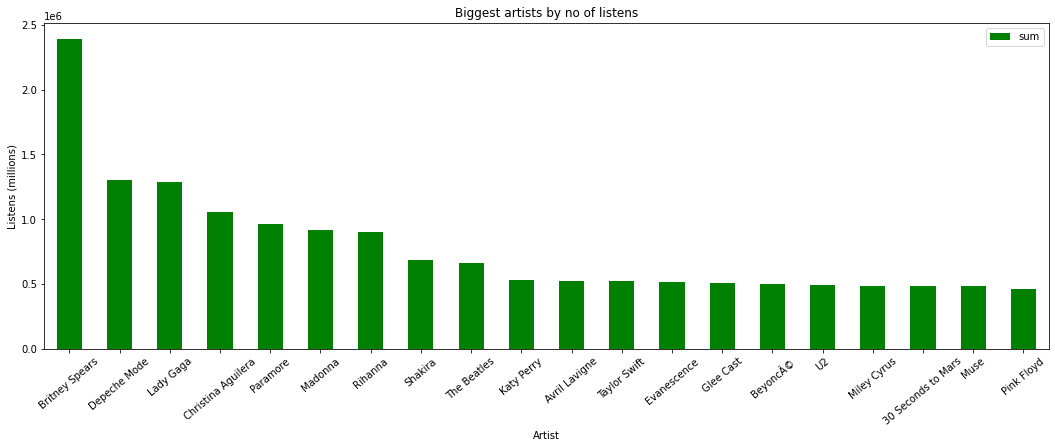

In [73]:
pt2.plot.bar(x = 'name', y = 'sum', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='Listens (millions)', title='Biggest artists by no of listens')

In [74]:
grouped_multiple = played.groupby(['userID']).agg({'played': ['mean', 'median', 'max', 'sum']})
grouped_multiple.columns = ['mean', 'med', 'max', 'sum']
grouped_multiple = grouped_multiple.reset_index()
#grouped_multiple.sort('price_mean', ascending=False)
grouped_multiple = pd.DataFrame(grouped_multiple)

In [75]:
userdf = grouped_multiple.sort_values(by=['sum'], ascending=False)

In [76]:
pt3 = userdf.head(20)

<AxesSubplot:title={'center':'Users with by no of listens'}, xlabel='User', ylabel='Listens'>

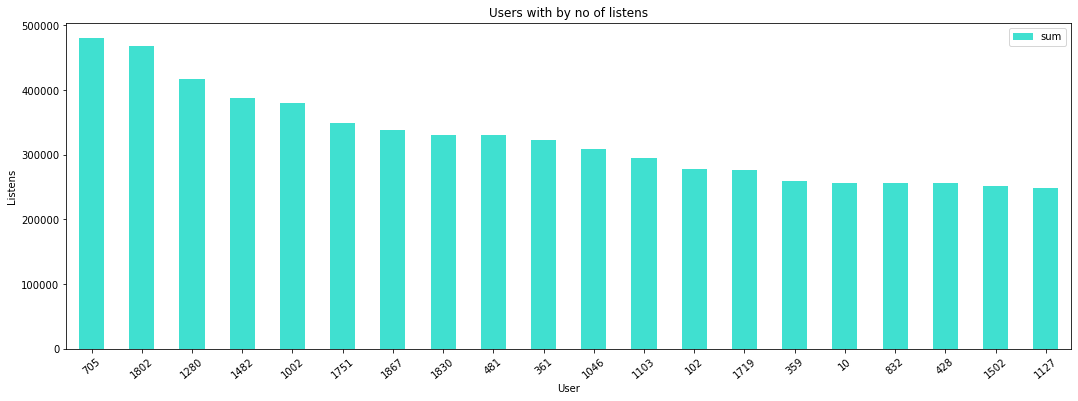

In [77]:
pt3.plot.bar(x = 'userID', y = 'sum', rot = 40, figsize=(18, 6), color='turquoise', xlabel='User', ylabel='Listens', title='Users with by no of listens')

In [78]:
artdf['mean']

283     4584.559
66      4614.567
83      2113.563
286     2600.504
492     2414.659
          ...   
16522      1.000
13713      1.000
13712      1.000
16239      1.000
16241      1.000
Name: mean, Length: 17632, dtype: float64

In [79]:
played.shape

(92834, 6)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

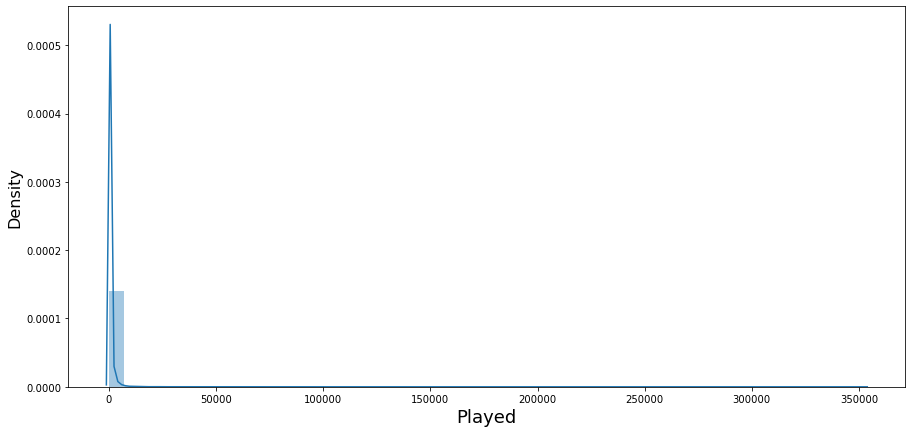

In [80]:
plt.figure(figsize=[15,7])
sns.distplot(played['played'])
plt.xlabel('Played', fontsize=18)
plt.ylabel('Density', fontsize=16)

In [81]:
xyz = pd.DataFrame(played['name'].value_counts())

In [82]:
xyz = xyz.reset_index()

In [83]:
xyz.rename(columns={'index': 'name', 'name': 'unique'}, inplace=True)

In [84]:
xyz

,name,unique
0,Lady Gaga,611
1,Britney Spears,522
2,Rihanna,484
3,The Beatles,480
4,Katy Perry,473
...,...,...
17627,I Built The Cross,1
17628,BOGULTA,1
17629,Junior Kelly,1
17630,The Other People Place,1


In [85]:
merged_df = artdf.merge(xyz, how = 'inner', on = ['name', 'name'])

In [86]:
merged_df

,artistID,name,mean,med,max,sum,unique
0,283,Britney Spears,4584.559,1000.500,131733,2393140,522
1,66,Depeche Mode,4614.567,567.000,352698,1301308,282
2,83,Lady Gaga,2113.563,590.000,114672,1291387,611
3,286,Christina Aguilera,2600.504,739.000,176133,1058405,407
4,492,Paramore,2414.659,417.000,227829,963449,399
...,...,...,...,...,...,...,...
17627,16522,K-Precise,1.000,1.000,1,1,1
17628,13713,ZÃœNDER,1.000,1.000,1,1,1
17629,13712,Evil Masquerade,1.000,1.000,1,1,1
17630,16239,Gosling,1.000,1.000,1,1,1


In [87]:
percent = []
val = merged_df['unique']
total = played['userID'].nunique()
percent = []
for i in range(len(val)):
    y = val[i] / total
    percent.append(y)
    #print(y)

In [88]:
percent = np.array(percent)
artdf['Percentage'] = percent.tolist()

In [89]:
artdf

,artistID,name,mean,med,max,sum,Percentage
283,283,Britney Spears,4584.559,1000.500,131733,2393140,0.276
66,66,Depeche Mode,4614.567,567.000,352698,1301308,0.149
83,83,Lady Gaga,2113.563,590.000,114672,1291387,0.323
286,286,Christina Aguilera,2600.504,739.000,176133,1058405,0.215
492,492,Paramore,2414.659,417.000,227829,963449,0.211
...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000,1.000,1,1,0.001
13713,13713,ZÃœNDER,1.000,1.000,1,1,0.001
13712,13712,Evil Masquerade,1.000,1.000,1,1,0.001
16239,16239,Gosling,1.000,1.000,1,1,0.001


In [90]:
artdf['unique'] = merged_df['unique'].values

In [91]:
artdf

,artistID,name,mean,med,max,sum,Percentage,unique
283,283,Britney Spears,4584.559,1000.500,131733,2393140,0.276,522
66,66,Depeche Mode,4614.567,567.000,352698,1301308,0.149,282
83,83,Lady Gaga,2113.563,590.000,114672,1291387,0.323,611
286,286,Christina Aguilera,2600.504,739.000,176133,1058405,0.215,407
492,492,Paramore,2414.659,417.000,227829,963449,0.211,399
...,...,...,...,...,...,...,...,...
16522,16522,K-Precise,1.000,1.000,1,1,0.001,1
13713,13713,ZÃœNDER,1.000,1.000,1,1,0.001,1
13712,13712,Evil Masquerade,1.000,1.000,1,1,0.001,1
16239,16239,Gosling,1.000,1.000,1,1,0.001,1


In [92]:
artdf['Percentage'] = artdf['Percentage'].multiply(100)

In [93]:
artdf = artdf.sort_values(by=['Percentage'], ascending=False)

<AxesSubplot:title={'center':'Percentage of users who listen to most popular artists'}, xlabel='Artist', ylabel='% of unique users who listen'>

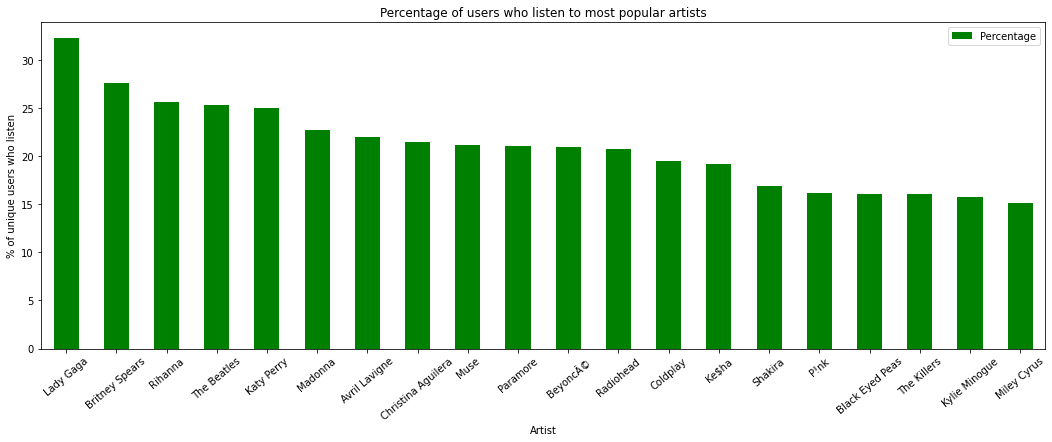

In [94]:
pt2 = artdf.head(20)
pt2.plot.bar(x = 'name', y = 'Percentage', rot = 40, figsize=(18, 6), color='green', xlabel='Artist', ylabel='% of unique users who listen', title='Percentage of users who listen to most popular artists')

In [274]:
values = [1, 2, 3, 4, 5]
for i in range(len(values)):
    x = len(artdf[artdf['Percentage'] <= values[i]])
    print("The percentage of artists with " + str(values[i]) + "% or less users listening to them is " + str(x) + ".")

The percentage of artists with 1% or less users listening to them is 16794.
The percentage of artists with 2% or less users listening to them is 17200.
The percentage of artists with 3% or less users listening to them is 17350.
The percentage of artists with 4% or less users listening to them is 17430.
The percentage of artists with 5% or less users listening to them is 17497.


We can tell on the whole of the 17632 artists that there are actually very few who are listened to by a wide audience. There are less than 1000 artists who have more than 1% of users listening to them. This means our data is probably leaned very heavily towards the most popular artists such as Britney Spears or Lady Gaga as per our barchart above.

In [96]:
z = played[['name', 'artistID']]

In [97]:
z = z.drop_duplicates()

In [98]:
z

,name,artistID
0,MALICE MIZER,0
3,Diary of Dreams,1
15,Carpathian Forest,2
18,Moi dix Mois,3
20,Bella Morte,4
...,...,...
92829,Diamanda GalÃ¡s,17627
92830,Aya RL,17628
92831,Coptic Rain,17629
92832,Oz Alchemist,17630


In [99]:
played

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152
...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286


In [100]:
played.head()

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152


I was going to try to incorporate the tags as part of my recommender system but as per above I seem to lose data just by the shape and even looking at artistID 1 we see this ID occurs three times in our played data and only twice in our tagged dataset. This is porbably due to the fact the users left no tags on this. We also have some improper values for tags as per above such as "better than lady gaga" and "#NAME?" which aren't going to add any information to our data. If we choose a subset of tags and take out values such as these that aren't as common or add any information we could work with this then. However, this would mean trimming our dataset down further. With less data to work with this might negatively impact the effectiveness of our recommender system.

In [101]:
df4[df4['artistID'] == 1]

,userID,artistID,tagID,day,month,year
3251,37,1,30,1,1,2009
3252,37,1,127,1,8,2009
3253,37,1,575,1,7,2008
21145,211,1,61,1,10,2009
26470,247,1,30,1,3,2008
...,...,...,...,...,...,...
147516,1515,1,179,1,1,2010
147517,1515,1,190,1,1,2010
147518,1515,1,575,1,1,2010
170778,1740,1,179,1,12,2006


This confirms that user 34 does not leave a tag on this artist's work. This is why we lose the rows we do when we try to incorporate the tags data into the listened data. We will disregard this for now.

# Sparse Representation of Played matrix

In [215]:
# Calculate sparsity of matrix
def calculate_sparsity(M):
    matrix_size = float(M.shape[0] * M.shape[1]) # Number of total possible interactions between artist and user in the matrix
    num_plays = len(M.nonzero()[1]) # Number of times any artist has been interacted with
    sparsity = 100 * (1 - float(num_plays / matrix_size))
    return sparsity

In [103]:
#sparsity = 1.0 - ( count_nonzero(A) / float(A.size) )
#print(sparsity)

In [104]:
played

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152
...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286


In [105]:
played.dtypes

name        object
url         object
artID        int64
userID       int64
artistID     int64
played       int64
dtype: object

In [216]:
def build_rating_sparse_tensor(ratings_df):
  # ========================= Complete this section ============================
    indices = ratings_df[['userID', 'artID']].values
    values = ratings_df['played'].values
  # ============================================================================

    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(played.userID.unique()), len(played.artID.unique())])

In [107]:
#print('Matrix Sparsity:', build_rating_sparse_tensor(xyz))

In [108]:
len(played.userID.unique())

1892

In [109]:
len(played[['userID', 'artistID']].values)

92834

In [110]:
len(played['played'].values)

92834

In [111]:
played.shape[0]

92834

In [112]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, artist_embeddings):
    predictions = tf.reduce_sum(
    tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) * tf.gather(artist_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

# Building Model

In [218]:
class CFModel(object):

  def __init__(self, embedding_vars, loss, metrics=None):

    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations = 100, learning_rate = 1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics) + 1
        fig = plt.figure()
        fig.set_size_inches(num_subplots * 10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i + 1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label = k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

# Build Model

In [193]:
from sklearn.model_selection import train_test_split
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  # Split the ratings DataFrame into train and test.
    #train_ratings, test_ratings = train_test_split(ratings, test_size=0.5)
    train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "userID": U,
      "artID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [186]:
def split_dataframe(df, holdout_fraction=0.1):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [269]:
xyz = played[['userID', 'artID', 'played']]

In [270]:
xyz[xyz["played"] > 2000]["played"] = 2000

indexes = xyz[xyz["played"] > 2000].index

xyz.iloc[indexes,2] = 2000

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [271]:
xyz["played"].max()

2000

In [272]:
xyz["played"] = xyz["played"] / xyz["played"].max()

<ipython-input-272-48c73cea43db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xyz["played"] = xyz["played"] / xyz["played"].max()


In [259]:
#xyz['userID'] = xyz['userID'].astype(str)
#xyz['artID'] = xyz['artID'].astype(str)
#xyz['played'] = xyz['played'].astype(float)
#xyz = xyz.sample(frac=1).reset_index(drop=True)

 iteration 1000: train_error=0.050026, test_error=0.609372

[{'train_error': 0.050025757, 'test_error': 0.6093721}]

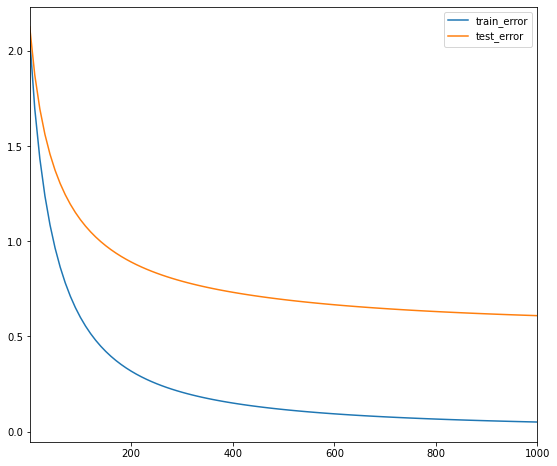

In [260]:
model = build_model(xyz,  embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

I tried to build my model but the high values for listens was giving me errors like so "InvalidArgumentError: indices[4073] = 2077 is not in [0, 1892)". 

This was why I changed the artist and user ID's to 1.) start from zero and 2.) increment by 1 until the length of unique values - 1. I had to normalise my weights then as I kept returning nan values for train and test errors above.

In [120]:
played.head(6)

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152
5,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,303,1,3466


In [121]:
#played[played["played"] > 2000]["played"] = 2000

<ipython-input-121-f8959ccb73cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  played[played["played"] > 2000]["played"] = 2000


In [122]:
#indexes = played[played["played"] > 2000].index

In [123]:
#indexes

Int64Index([    5,    67,    76,   115,   126,   133,   141,   150,   160,
              174,
            ...
            92584, 92672, 92673, 92674, 92675, 92676, 92683, 92684, 92756,
            92757],
           dtype='int64', length=5721)

In [124]:
#played.iloc[indexes,5] = 2000

In [125]:
#played.head(6)

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152
5,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,303,1,2000


In [126]:
#played.head()

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152


# Inspect Embeddings

In [261]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [262]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  df[df['name'].str.contains(title_substring)].index.values
  titles = df.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artist with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artID"][artistID], model.embeddings["artID"],
      measure)
  score_key = measure + ' score'
  df7 = pd.DataFrame({
      score_key: list(scores),
      'names': df['name'],
  })
  display.display(df7.sort_values([score_key], ascending=False).head(k))

In [263]:
artist_neighbors(model, "Lady Gaga", DOT)
artist_neighbors(model, "Lady Gaga", COSINE)

Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,dot score,names
8200,2.733,12012
9589,2.165,The Smithereens
13672,2.122,Ray Charles And Betty Carter
12509,1.907,Thea Gilmore
12189,1.844,Joe Colombo
6018,1.839,John Stoneham


Nearest neighbors of : Lady Gaga.
[Found more than one matching artist. Other candidates: Lady Gaga VS Christina Aguilera, BeyoncÃ© e Lady Gaga, Lady Gaga feat BeyoncÃ©]


,cosine score,names
83,1.000,Lady Gaga
282,0.973,Rihanna
283,0.967,Britney Spears
294,0.948,Katy Perry
285,0.946,Kelly Clarkson
460,0.945,Ke$ha


# Regularized Matrix

In [264]:
def gravity(U, V):
  return 1. / (U.shape[0].value * V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a = True) * tf.matmul(V, V, transpose_a = True))

def build_regularized_model(data, embedding_dim = 3, regularization_coeff = .1, gravity_coeff = 1., init_stddev = 0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(xyz)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U * U) / U.shape[0].value + tf.reduce_sum(V * V) / V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userID": U, "artID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

 iteration 2000: train_error_observed=0.036700, test_error_observed=0.061432, observed_loss=0.036700, regularization_loss=0.024406, gravity_loss=0.002461

[{'train_error_observed': 0.03669981, 'test_error_observed': 0.061432138},
 {'observed_loss': 0.03669981,
  'regularization_loss': 0.024406305,
  'gravity_loss': 0.0024606825}]

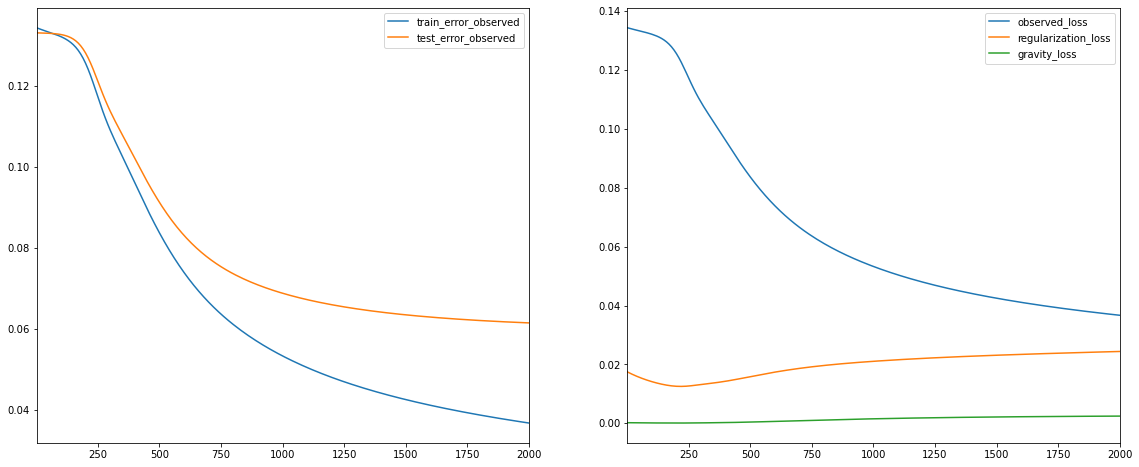

In [265]:
reg_model, u, v  = build_regularized_model(xyz, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35, init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [266]:
artist_neighbors(reg_model, "The Killers", DOT)
artist_neighbors(reg_model, "The Killers", COSINE)

Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,dot score,names
223,2.527,The Killers
184,2.292,Muse
59,2.008,Coldplay
673,1.921,Glee Cast
221,1.854,The Beatles
492,1.615,Paramore


Nearest neighbors of : The Killers.
[Found more than one matching artist. Other candidates: Arctic Monkeys vs The Killers]


,cosine score,names
223,1.000,The Killers
4035,0.768,The Postal Service
176,0.768,Keane
3077,0.762,Matchbox Twenty
215,0.760,Travis
710,0.754,Kaiser Chiefs


In [267]:
xyz.head()

,userID,artID,played
0,31,0,0.106
1,256,0,0.241
2,729,0,0.038
3,130,1,0.510
4,240,1,0.076


# Alternate method

In [127]:
played.shape

(92834, 6)

In [128]:
played.dtypes

name        object
url         object
artID        int64
userID       int64
artistID     int64
played       int64
dtype: object

In [129]:
played.head()

,name,url,artID,userID,artistID,played
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152


In [130]:
sub = played[['userID', 'artID', 'played']]

In [131]:
#sub.rename(columns={'mapped1': 'userID', 'mapped': 'artistID'}, inplace=True)

In [132]:
sub

,userID,artID,played
0,31,0,212
1,256,0,483
2,729,0,76
3,130,1,1021
4,240,1,152
...,...,...,...
92829,423,17627,301
92830,423,17628,294
92831,423,17629,287
92832,423,17630,286


In [133]:
train, test = train_test_split(sub, test_size=0.7)

In [134]:
train.head()

,userID,artID,played
39393,686,923,301
70915,866,4632,606
50547,1270,1495,647
72766,271,5171,21
1380,1049,53,20


In [135]:
test.head()

,userID,artID,played
79267,751,7811,1550
4778,1869,148,141
13044,1380,282,726
27176,10,504,1341
88017,1194,13237,7


In [136]:
n_users = len(sub.userID.unique())
n_users

1892

In [137]:
n_artist = len(sub.artID.unique())
n_artist

17632

In [138]:
# creating artist embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artist")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([artist_vec, user_vec])
model = Model([user_input, artist_input], prod)
model.compile('adam', 'mean_squared_error')

In [139]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    history = model.fit([train.userID, train.artID], train.played, epochs=5, verbose=1)
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [140]:
model.evaluate([test.userID, test.artID], test.played)

538262.4280553674

In [141]:
predictions = model.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.played.iloc[i]) for i in range(0,10)]

[0.96282244] 1550
[7.364946] 141
[7.9718275] 726
[1.653015] 1341
[0.49596632] 7
[2.295187] 222
[0.7292818] 356
[-0.00850168] 114
[0.1537747] 115
[0.23418576] 172


[None, None, None, None, None, None, None, None, None, None]

# Neural Network

In [142]:
# creating book embedding path
artist_input = Input(shape=[1], name="Artist-Input")
artist_embedding = Embedding(n_artist + 1, 5, name="Artist-Embedding")(artist_input)
artist_vec = Flatten(name="Flatten-Artists")(artist_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([artist_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, artist_input], out)
model2.compile('adam', 'mean_squared_error')

In [143]:
from keras.models import load_model

if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model2.fit([train.userID, train.artID], train.played, epochs=5, verbose=1)
    model2.save('regression_model2.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [144]:
model2.evaluate([test.userID, test.artID], test.played)

1095690.5062669273

In [145]:
predictions = model2.predict([test.userID.head(10), test.artID.head(10)])

[print(predictions[i], test.played.iloc[i]) for i in range(0,10)]

[468.85538] 1550
[277.51068] 141
[698.7527] 726
[4157.0303] 1341
[233.92842] 7
[363.44968] 222
[274.58243] 356
[1847.2295] 114
[774.63477] 115
[237.19608] 172


[None, None, None, None, None, None, None, None, None, None]

# Visualizing Embeddings

In [146]:
# Extract embeddings
artist_em = model.get_layer("Artist-Embedding")
artist_em_weights = artist_em.get_weights()[0]

In [147]:
artist_em_weights[:5]

array([[ 0.04103883, -0.2710777 ,  0.28193265,  0.01121594, -0.21962109],
       [ 0.42227656, -0.44878516,  0.46648487, -0.12221594, -0.40105212],
       [-0.18079431, -0.13342255,  0.1553544 , -0.3333101 , -0.00778394],
       [ 0.150518  , -0.19249448,  0.1592992 ,  0.12258738, -0.12723902],
       [ 0.2513393 , -0.21272472,  0.1814355 , -0.22018886, -0.13649407]],
      dtype=float32)

<AxesSubplot:>

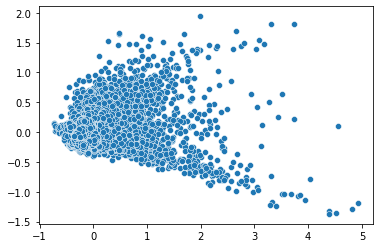

In [148]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [149]:
artist_em_weights = artist_em_weights / np.linalg.norm(artist_em_weights, axis = 1).reshape((-1, 1))
artist_em_weights[0][:10]
np.sum(np.square(artist_em_weights[0]))

1.0

<AxesSubplot:>

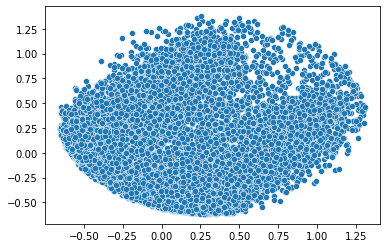

In [150]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(artist_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [151]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(artist_em_weights)

C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17633 samples in 0.046s...
[t-SNE] Computed neighbors for 17633 samples in 1.727s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17633
[t-SNE] Computed conditional probabilities for sample 2000 / 17633
[t-SNE] Computed conditional probabilities for sample 3000 / 17633
[t-SNE] Computed conditional probabilities for sample 4000 / 17633
[t-SNE] Computed conditional probabilities for sample 5000 / 17633
[t-SNE] Computed conditional probabilities for sample 6000 / 17633
[t-SNE] Computed conditional probabilities for sample 7000 / 17633
[t-SNE] Computed conditional probabilities for sample 8000 / 17633
[t-SNE] Computed conditional probabilities for sample 9000 / 17633
[t-SNE] Computed conditional probabilities for sample 10000 / 17633
[t-SNE] Computed conditional probabilities for sample 11000 / 17633
[t-SNE] Computed conditional probabilities for sample 12000 / 17633
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:>

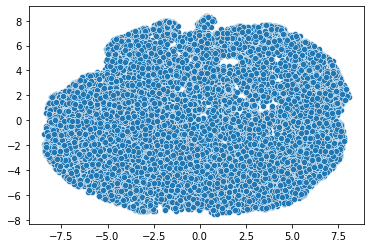

In [152]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

# Making Recommendations

In [153]:
# Creating dataset for making recommendations for the first user
artist_data = np.array(list(set(sub.artID)))
artist_data

array([    0,     1,     2, ..., 17629, 17630, 17631])

In [154]:
user = np.array([83 for i in range(len(artist_data))])
user

array([83, 83, 83, ..., 83, 83, 83])

In [155]:
predictions = model.predict([user, artist_data])

predictions = np.array([a[0] for a in predictions])

recommended_artist_ids = (predictions).argsort()[:5]

recommended_artist_ids

array([8131, 8135, 8324, 2754, 8139], dtype=int64)

In [156]:
predictions[recommended_artist_ids]

array([-1.1105492 , -1.0870131 , -1.0431927 , -0.9887378 , -0.98679465],
      dtype=float32)

In [157]:
df[df['artID'].isin(recommended_artist_ids)]

,name,url,pictureURL,artID
2754,Dark Funeral,http://www.last.fm/music/Dark+Funeral,http://userserve-ak.last.fm/serve/252/13074411...,2754
8131,Nahash,http://www.last.fm/music/Nahash,http://userserve-ak.last.fm/serve/252/93322.jpg,8131
8135,Krabaras,http://www.last.fm/music/Krabaras,http://userserve-ak.last.fm/serve/252/44372179...,8135
8139,Luctus,http://www.last.fm/music/Luctus,http://userserve-ak.last.fm/serve/252/8688989.jpg,8139
8324,Dissimulation,http://www.last.fm/music/Dissimulation,http://userserve-ak.last.fm/serve/252/16340589...,8324


In [158]:
played[played['userID'] == 98]

,name,url,artID,userID,artistID,played
681,Air,http://www.last.fm/music/Air,47,98,47,36
1501,RÃ¶yksopp,http://www.last.fm/music/R%C3%B6yksopp,58,98,58,56
1582,Coldplay,http://www.last.fm/music/Coldplay,59,98,59,53
2588,Depeche Mode,http://www.last.fm/music/Depeche+Mode,66,98,66,1733
2865,Camouflage,http://www.last.fm/music/Camouflage,69,98,69,66
...,...,...,...,...,...,...
60634,Bill,http://www.last.fm/music/Bill,2627,98,2627,31
60635,The Beat,http://www.last.fm/music/The+Beat,2628,98,2628,28
60636,Alfonso Moreno-Guitar,http://www.last.fm/music/Alfonso+Moreno-Guitar,2629,98,2629,22
60637,Bozkurt,http://www.last.fm/music/Bozkurt,2630,98,2630,20


We will look at tag information related to recommendations and see do they represent good recommendations.

# Alternate Method 2

In [159]:
pc = played.played
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())

played = played.assign(playCountScaled=play_count_scaled)

In [160]:
played

,name,url,artID,userID,artistID,played,playCountScaled
0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,31,0,212,0.106
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,256,0,483,0.241
2,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,0,729,0,76,0.038
3,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,130,1,1021,0.510
4,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,1,240,1,152,0.076
...,...,...,...,...,...,...,...
92829,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,17627,423,17627,301,0.150
92830,Aya RL,http://www.last.fm/music/Aya+RL,17628,423,17628,294,0.147
92831,Coptic Rain,http://www.last.fm/music/Coptic+Rain,17629,423,17629,287,0.143
92832,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,17630,423,17630,286,0.143


In [161]:
ratings_df = played.pivot(
    index='userID', 
    columns='artistID', 
    values='playCountScaled'
)

In [162]:
ratings = ratings_df.fillna(0).values

In [163]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.28%


In [164]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) >= MIN_USER_RATINGS:
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=DELETE_RATING_COUNT,
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [165]:
train, val = train_test_split(ratings)

In [166]:
train.shape

(1892, 17632)

In [167]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [168]:
class Recommender:
  
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate
  
  def predictions(self, P, Q):
    return np.dot(P.T, Q)
  
  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)
    
    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()
    
    for epoch in range(self.n_epochs):
        for u, i in zip(users, items):
            error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
            self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
            self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

        train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
        val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
        self.train_error.append(train_rmse)
        self.val_error.append(val_rmse)
        
    return self
  
  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [169]:
recommender = Recommender().fit(train, val)

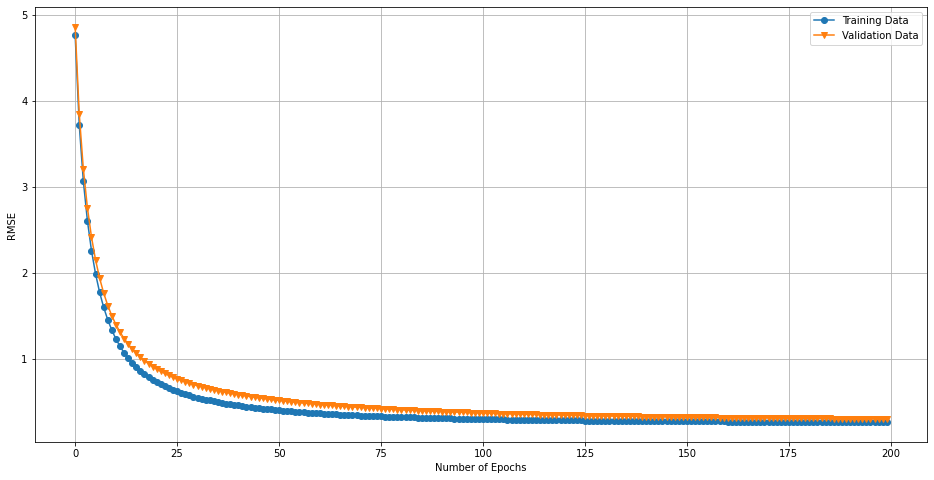

In [170]:
plt.figure(figsize=(16,8))
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

## Making Recommendations

In [171]:
user_id = 15
user_index = ratings_df.index.get_loc(user_id)
predictions_index = np.where(train[user_index, :] == 0)[0]

rating_predictions = recommender.predict(train, user_index)

In [172]:
def create_artist_ratings(artists_df, artists_index, ratings, n=10):
    artist_ids = ratings_df.columns[artists_index]
    artist_ratings = pd.DataFrame(data=dict(artistId=artist_ids, rating=ratings))
    top_n_artists = artist_ratings.sort_values("rating", ascending=False).head(n)
  
    artist_recommendations = artists_df[artists_df.artID.isin(top_n_artists.artistId)].reset_index(drop=True)
    artist_recommendations['rating'] = pd.Series(top_n_artists.rating.values)
    return artist_recommendations.sort_values("rating", ascending=False)

In [173]:
existing_ratings_index = np.where(train[user_index, :] > 0)[0]
existing_ratings = train[user_index, existing_ratings_index]

create_artist_ratings(df, existing_ratings_index, existing_ratings)

,name,url,pictureURL,artID,rating
0,Lady Gaga,http://www.last.fm/music/Lady+Gaga,http://userserve-ak.last.fm/serve/252/47390093...,83,1.000
1,The Killers,http://www.last.fm/music/The+Killers,http://userserve-ak.last.fm/serve/252/250099.jpg,223,0.723
2,Katy Perry,http://www.last.fm/music/Katy+Perry,http://userserve-ak.last.fm/serve/252/42128121...,294,0.627
3,Adam Lambert,http://www.last.fm/music/Adam+Lambert,http://userserve-ak.last.fm/serve/252/56430315...,538,0.544
4,Ellie Goulding,http://www.last.fm/music/Ellie+Goulding,http://userserve-ak.last.fm/serve/252/62251875...,542,0.445
5,Glee Cast,http://www.last.fm/music/Glee+Cast,http://userserve-ak.last.fm/serve/252/44433851...,673,0.325
6,The Veronicas,http://www.last.fm/music/The+Veronicas,http://userserve-ak.last.fm/serve/252/31471795...,674,0.305
7,Lights,http://www.last.fm/music/Lights,http://userserve-ak.last.fm/serve/252/40210269...,676,0.237
8,John Mayer,http://www.last.fm/music/John+Mayer,http://userserve-ak.last.fm/serve/252/385672.jpg,677,0.231
9,American Idiot Cast,http://www.last.fm/music/American+Idiot+Cast,http://userserve-ak.last.fm/serve/252/53866529...,678,0.213


In [174]:
create_artist_ratings(df, predictions_index, rating_predictions)

,name,url,pictureURL,artID,rating
0,Vitamin Z,http://www.last.fm/music/Vitamin+Z,http://userserve-ak.last.fm/serve/252/197506.jpg,86,0.963
1,Lunar Aurora,http://www.last.fm/music/Lunar+Aurora,http://userserve-ak.last.fm/serve/252/360713.jpg,3732,0.949
2,Liquid Divine,http://www.last.fm/music/Liquid+Divine,http://userserve-ak.last.fm/serve/252/37816493...,3980,0.945
3,Monopoly Child Star Searchers,http://www.last.fm/music/Monopoly+Child+Star+S...,http://userserve-ak.last.fm/serve/252/53743983...,5750,0.938
4,Dissimulation,http://www.last.fm/music/Dissimulation,http://userserve-ak.last.fm/serve/252/16340589...,8324,0.937
5,Halina Benedyk,http://www.last.fm/music/Halina+Benedyk,http://userserve-ak.last.fm/serve/252/44469303...,8787,0.935
6,PH Electro - [muz-zone.net],http://www.last.fm/music/PH+Electro+-+%5Bmuz-z...,NaN,11031,0.933
7,Rainer Maria,http://www.last.fm/music/Rainer+Maria,http://userserve-ak.last.fm/serve/252/541917.jpg,11130,0.932
8,Keshco,http://www.last.fm/music/Keshco,http://userserve-ak.last.fm/serve/252/110580.jpg,11500,0.931
9,Ð§ÐµÑ‚Ñ‹Ñ€Ðµ Ñ‚Ð°Ñ€Ð°ÐºÐ°Ð½Ð°,http://www.last.fm/music/%D0%A7%D0%B5%D1%82%D1...,http://userserve-ak.last.fm/serve/252/198331.jpg,16340,0.929


In [175]:
df4.head()

,userID,artistID,tagID,day,month,year
0,0,49,13,1,4,2009
1,0,49,15,1,4,2009
2,0,49,18,1,4,2009
3,0,49,21,1,4,2009
4,0,49,41,1,4,2009


In [176]:
df4.drop(columns=['day', 'month', 'year'], inplace=True)

In [177]:
df4.head()

,userID,artistID,tagID
0,0,49,13
1,0,49,15
2,0,49,18
3,0,49,21
4,0,49,41


In [178]:
df1.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [179]:
tags = pd.merge(df1, df4, how="inner", left_on="tagID", right_on="tagID")

In [180]:
tags.isnull().values.any()

False

In [181]:
tags.head()

,tagID,tagValue,userID,artistID
0,1,metal,2,821
1,1,metal,10,151
2,1,metal,10,168
3,1,metal,10,450
4,1,metal,10,453


<AxesSubplot:>

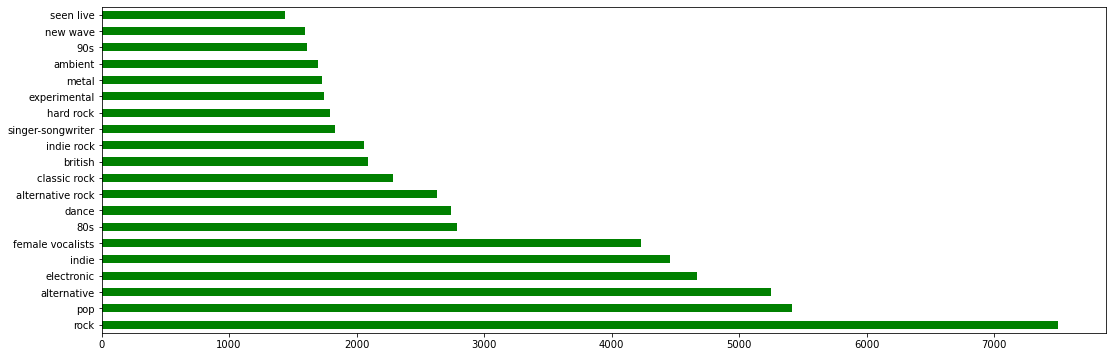

In [182]:
tags['tagValue'].value_counts()[:20].plot(kind='barh', color='green', figsize=(18,6))